## Entregable 2

Somos una empresa farmacéutica y queremos desarrollar nuevos fármacos y experimentos. Las experimentaciones en el sector farmacéutico son públicas y en este ejercicio se recoge una pequeña muestra de 5 referencias.
El ejercicio consiste en crear una tabla en la que cada fila sea la información de cada documento, y cada columna sea una variable de interés. Puede ocurrir que la variable de interés no aparezca en todos los documentos, en cuyo caso se pide imputar un nulo.

Para llevar a cabo este ejercicio se propone utilizar una LLM que se puede descargar en local a través de:
* https://huggingface.co/models?other=LLM

# **Análisis de Variables en Documentos Académicos**

Este proyecto analiza documentos académicos relacionados con nutrición y su impacto en la ganancia de masa muscular, pérdida de peso y mejora de la composición corporal. A través de técnicas de análisis y visualización de datos, identificamos las variables más recurrentes en los documentos.

## **1. Carga de los Datos**

**Extraccion del texto de los PDFs**

In [8]:
from PyPDF2 import PdfReader

def extract_text_from_pdf(pdf_path, max_length):
    """
    Extrae texto de un archivo PDF y lo trunca si supera el límite especificado.
    """
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"
    
    # Truncar si el texto excede el límite
    if len(text) > max_length:
        print(f"El texto extraído de {pdf_path} excede el límite de {max_length} caracteres. Será truncado.")
        # Buscar el último espacio antes del límite para truncar limpiamente
        cut_index = text.rfind(" ", 0, max_length)
        if cut_index == -1:  # Si no encuentra un espacio, corta directamente
            cut_index = max_length
        text = text[:cut_index]
    
    return text


pdf_files = [
    'pdf/pdf_1.pdf',
    'pdf/pdf_2.pdf',
    'pdf/pdf_3.pdf',
    'pdf/pdf_4.pdf',
    'pdf/pdf_5.pdf',
]

# Define el límite de caracteres
limite_caracteres = 800000

# Lista para guardar los textos extraídos
texto = [None] * len(pdf_files)

# Extraer texto con truncamiento
for i, pdf in enumerate(pdf_files):
    texto[i] = extract_text_from_pdf(pdf, limite_caracteres)

# Imprimir un resumen de los textos
for idx, txt in enumerate(texto):
    print(f"\n--- Texto del archivo {pdf_files[idx]} ---\n")
    print(f"Longitud: {len(txt)} caracteres")
    print(txt[:500])  # Muestra los primeros 500 caracteres para verificar



--- Texto del archivo pdf/pdf_1.pdf ---

Longitud: 60791 caracteres
   1 of 10
Morton RW, et al. Br J Sports Med 2018;52:376–384. doi:10.1136/bjsports-2017-097608A systematic review, meta-analysis and meta-
regression of the effect of protein supplementation on resistance training-induced gains in muscle mass and strength in healthy adults
Robert W Morton,1 Kevin T Murphy,1 Sean R McKellar,1 Brad J Schoenfeld,2 
Menno Henselmans,3 Eric Helms,4 Alan A Aragon,5 Michaela C Devries,6 
Laura Banfield,7 James W Krieger,8 Stuart M Phillips1 Review
To cite: Morton RW, 


--- Texto del archivo pdf/pdf_2.pdf ---

Longitud: 31688 caracteres
The Journal of Nutrition
Nutrient Requirements and Optimal Nutrition
Dietary Protein Distribution Positively Inﬂuences
24-h Muscle Protein Synthesis in Healthy Adults1–3
Madonna M. Mamerow,4Joni A. Mettler,4Kirk L. English,4Shanon L. Casperson,6Emily Arentson-Lantz,4
Melinda Shefﬁeld-Moore,6Donald K. Layman,7and Douglas Paddon-Jones4,5*
4Division of Rehabilit

In [2]:
print(texto[2])

REVIEW Open Access
How much protein can the body use in a
single meal for muscle-building?
Implications for daily protein distribution
Brad Jon Schoenfeld1*and Alan Albert Aragon2
Abstract
Controversy exists about the maximum amount of protein that can be utilized for lean tissue-building purposes in a
single meal for those involved in regimented resistance training. It has been proposed that muscle protein synthesis is
maximized in young adults with an intake of ~ 20 –25 g of a high-quality protein; anything above this amount is
believed to be oxidized for energy or transaminated to form urea and other organic acids. However, these findings are
specific to the provision of fast-digesting proteins without the addition of other macronutrients. Consumption of
slower-acting protein sources, particularly when consumed in combination with other macronutrients, would delay
absorption and thus conceivably enhance the utilization of the constituent amino acids. The purpose of this paper was
tw

## **2. ETL con AI**

**Resumen de los textos con IA para intentar no pasarnos de los tokens permitidos por openai para crear el df**

In [9]:
import dotenv
import openai
import os

dotenv.load_dotenv()

def summarize_text_with_openai(text):
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an assistant who summarizes academic texts. There is a summary but in the above countries possible relevant information from the study, we want to eliminate some information but not important things."},
                {"role": "user", "content": f"Por favor, resume este texto: {text}"}
            ],
            temperature=0.3,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error al procesar el texto con la API: {e}")
        return None
    
for item in texto:
    item = summarize_text_with_openai(item)


In [10]:
print (texto[2])

REVIEW Open Access
How much protein can the body use in a
single meal for muscle-building?
Implications for daily protein distribution
Brad Jon Schoenfeld1*and Alan Albert Aragon2
Abstract
Controversy exists about the maximum amount of protein that can be utilized for lean tissue-building purposes in a
single meal for those involved in regimented resistance training. It has been proposed that muscle protein synthesis is
maximized in young adults with an intake of ~ 20 –25 g of a high-quality protein; anything above this amount is
believed to be oxidized for energy or transaminated to form urea and other organic acids. However, these findings are
specific to the provision of fast-digesting proteins without the addition of other macronutrients. Consumption of
slower-acting protein sources, particularly when consumed in combination with other macronutrients, would delay
absorption and thus conceivably enhance the utilization of the constituent amino acids. The purpose of this paper was
tw

**Busqueda de las variables en cada PDF y conversion a PDF**

In [36]:
import pandas as pd# List of important variables in English
variables_importantes = [
    "Protein Intake",                 # Ingesta de proteínas
    "Protein Distribution",           # Distribución de proteínas
    "Sources of Protein",             # Fuentes de proteínas
    "Muscle Protein Synthesis (MPS)", # Síntesis de proteínas musculares
    "Effect of Resistance Training",  # Efecto del entrenamiento de resistencia
    "Supplementation Strategies",     # Estrategias de suplementación
    "Anabolic Window",                # Ventana anabólica
    "Macronutrient Distribution",     # Distribución de macronutrientes
    "Target Population",              # Población objetivo
    "Study Methodology",              # Metodología del estudio
    "Key Results",                    # Resultados clave
    "Conclusions and Recommendations",# Conclusiones y recomendaciones
    "Weight Loss",                    # Pérdida de peso
    "Weight Gain",                    # Ganancia de peso
    "Muscle Gain",                    # Ganancia de músculo
    "Muscle Loss",                    # Pérdida de músculo
    "Body Composition Improvement",   # Mejora de la composición corporal
    "Caloric Intake",                 # Ingesta calórica
    "Energy Expenditure",             # Gasto energético
    "Fat Loss",                       # Pérdida de grasa
    "Fat Gain"                        # Ganancia de grasa
]

def generate_prompt(text, variables):
    # Generar una lista de las variables en el formato del prompt
    variables_list = "\n".join([f"- {var}" for var in variables])
    
    # Estructura del prompt
    prompt = f"""
You are an assistant analyzing academic papers. Your task is to check whether the following variables are present in the provided text. For each variable, return `True` if it is present and `False` if it is not. The output must be a single line in CSV format, with the variable names as headers.

Variables:
{variables_list}

Text:
{text}

Output format:
Variable1,Variable2,Variable3,...
True/False,True/False,True/False,...
    """
    return prompt


def analyze_text_with_openai(text, variables):
    prompt = generate_prompt(text, variables)
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an assistant for academic paper analysis."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
        )
        # Extraer la respuesta en CSV
        csv_line = response.choices[0].message.content
        return csv_line
    except Exception as e:
        print(f"Error: {e}")
        return None


respuestas = []
for text in texto:
    csv_line = analyze_text_with_openai(text, variables_importantes)
    if csv_line:
        respuestas.append(csv_line)

columns = respuestas[0].split("\n")[0].split(",")  # Cabecera de la primera respuesta
data = []

# Procesar cada respuesta
for response in respuestas:
    row_values = response.split("\n")[1].split(",")
    # Asegurarse de que la fila tenga la misma longitud que las columnas
    if len(row_values) < len(columns):
        row_values += ["False"] * (len(columns) - len(row_values))  # Rellenar faltantes con False
    elif len(row_values) > len(columns):
        row_values = row_values[:len(columns)]  # Truncar si hay valores extra
    data.append(row_values)

# Crear el DataFrame
df = pd.DataFrame(data, columns=columns)

df.head()

,Protein Intake,Protein Distribution,Sources of Protein,Muscle Protein Synthesis (MPS),Effect of Resistance Training,Supplementation Strategies,Anabolic Window,Macronutrient Distribution,Target Population,Study Methodology,...,Conclusions and Recommendations,Weight Loss,Weight Gain,Muscle Gain,Muscle Loss,Body Composition Improvement,Caloric Intake,Energy Expenditure,Fat Loss,Fat Gain
0,True,True,True,True,True,True,False,False,True,True,...,True,True,False,False,True,False,True,True,False,False
1,True,True,True,True,True,False,False,False,True,True,...,True,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,False,False,False,True,...,True,False,False,True,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,True,False,True,False,False,False
4,True,True,True,True,True,True,False,False,False,True,...,True,False,False,True,False,False,False,False,False,False


## **3. Visualización de Resultados**

/tmp/ipykernel_16270/535499286.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df.replace({"True": 1, "False": 0})
/tmp/ipykernel_16270/535499286.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mention_counts, x='Variable', y='Mentions', palette='viridis', edgecolor='black')


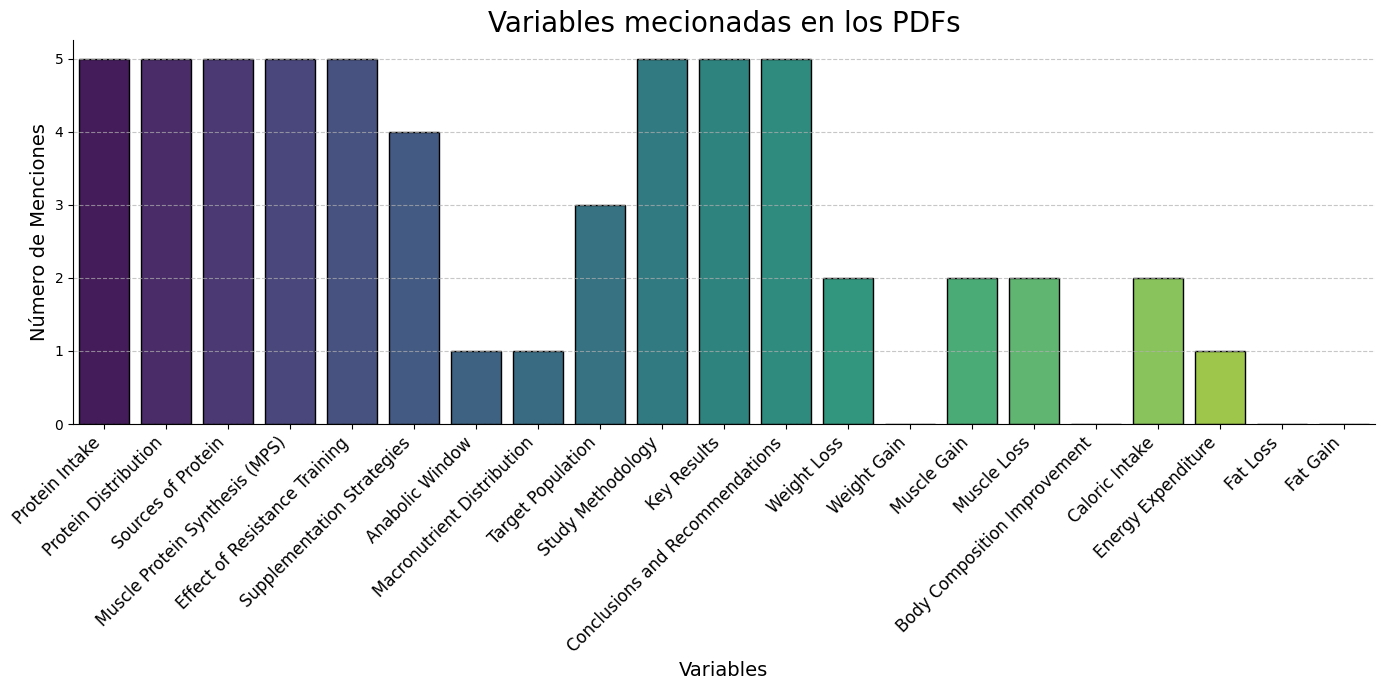

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir valores True/False a 1/0 para análisis
df_numeric = df.replace({"True": 1, "False": 0})

# Sumar menciones de cada variable
mention_counts = df_numeric.sum().reset_index()
mention_counts.columns = ['Variable', 'Mentions']

# Crear el gráfico de barras con seaborn
plt.figure(figsize=(14, 7))
sns.barplot(data=mention_counts, x='Variable', y='Mentions', palette='viridis', edgecolor='black')

# Configurar estilo del gráfico
plt.title("Variables mecionadas en los PDFs", fontsize=20)
plt.ylabel("Número de Menciones", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()
